Please go through the "building_strategies" notebook before looking at this notebook.

Lets work on optimizing our strategy parameters for the Bollinger Band&copy; we previously built.  We will include a function from the examples folder called build_example_strategy which builds this strategy.

In [1]:
import math
from types import SimpleNamespace
import pandas as pd
import numpy as np
import pyqstrat as pq
from pyqstrat.evaluator import compute_sharpe, compute_sortino, compute_maxdd_pct, compute_amean, compute_rolling_dd
from pyqstrat.evaluator import compute_periods_per_year
from pyqstrat.notebooks.support.build_example_strategy import build_example_strategy

pq.ContractGroup.clear()

Lets try to optimize the the lookback period for the moving average and the number of standard deviations for the bands.

We will try to optimize the sharpe ratio but also look at the sortino and max drawdown as we optimize the sharpe.

To do this, we have to write a generator function and a cost function.  The generator produces all the combinations of parameters you want to optimize.  The cost function will run the strategy for each parameter combination provided by the generator and return whatever metric you want to optimize, as well as any other metrics you want to see at the same time.

In this case, our cost metric will be the sharpe ratio of the strategy but we will also look at sortino and drawdowns at the same time. We also look at the number of trades generate and ignore results as unreliable if the number of trades is less than 10.

The optimizer uses multiple processes to run as fast as possible.  You can set the number of processes you want to use using the max_processes argument to the Optimizer constructor.  If you don't set this, the optimizer will the same number of processes as the CPU cores on your machine.  You may want to increase this number if your backtesting is I/O bound, and the CPU cores are often idle waiting for disk or other resources.

In this case, we are optimizing 2 parameters at the same time, but we can optimize 1 parameter or more than 2 as well.

<Figure size 432x288 with 0 Axes>

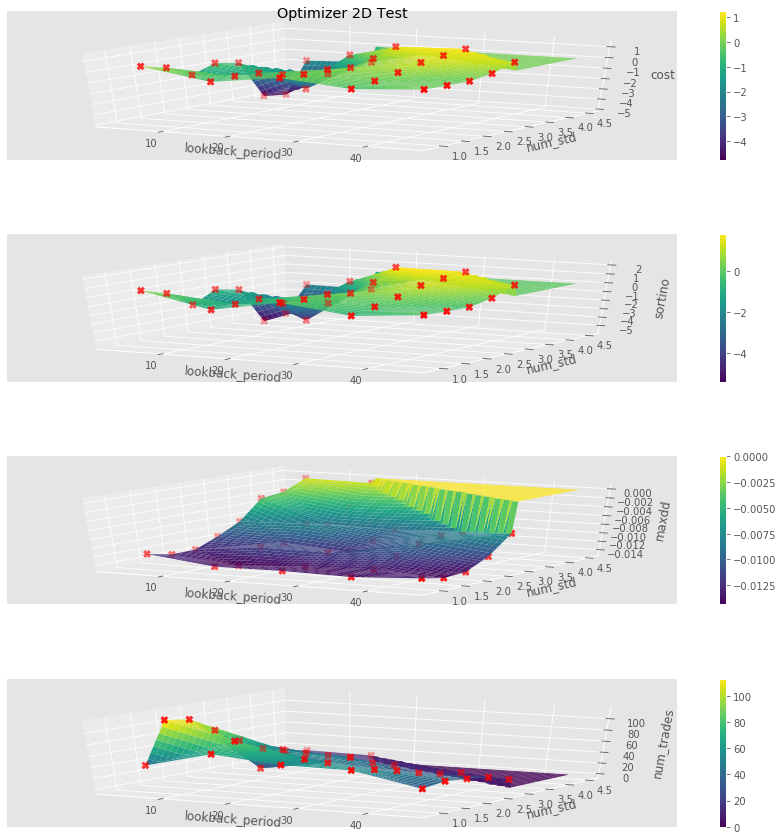

In [2]:
def generator():
    for lookback_period in np.arange(5, 50, 10): 
        for num_std in np.arange(1, 5, 0.5): # number of standard deviations the bands are away from the SMA
            costs = (yield {'lookback_period' : lookback_period, 'num_std' : num_std})
            yield
            
def cost_func(suggestion):
    strategy_context = SimpleNamespace(lookback_period = suggestion['lookback_period'], num_std = suggestion['num_std'])
    
    strategy = build_example_strategy(strategy_context)
    strategy.run()
    
    returns_df = strategy.df_returns().set_index('timestamp')
    
    num_trades = len(strategy.df_trades())
    
    if num_trades < 10: return np.nan, {}
    
    returns = returns_df.ret.values
    equity = returns_df.equity.values
    dates = returns_df.index.values
    
    periods_per_year = compute_periods_per_year(dates)
    
    amean = compute_amean(returns)
    sharpe = compute_sharpe(returns, amean, periods_per_year)
    sortino = compute_sortino(returns, amean, periods_per_year)
    rolling_dd = compute_rolling_dd(dates, equity)
    maxdd = compute_maxdd_pct(rolling_dd)
    
    return sharpe, {'sortino' : sortino, 'maxdd' : maxdd, 'num_trades' : num_trades}

optimizer = pq.Optimizer('example', generator(), cost_func, max_processes = 8)
optimizer.run(raise_on_error = True)

optimizer.plot_3d(x = 'lookback_period', y = 'num_std', hspace = 0.5);

There seems to be a region around a lookback period of 35 bars and 3 standard deviations that has a positive sharpe and sortino.  The actual points you provided to the plot are shown with red X markers.

Let's build a contour plot to see the same data in a different view.

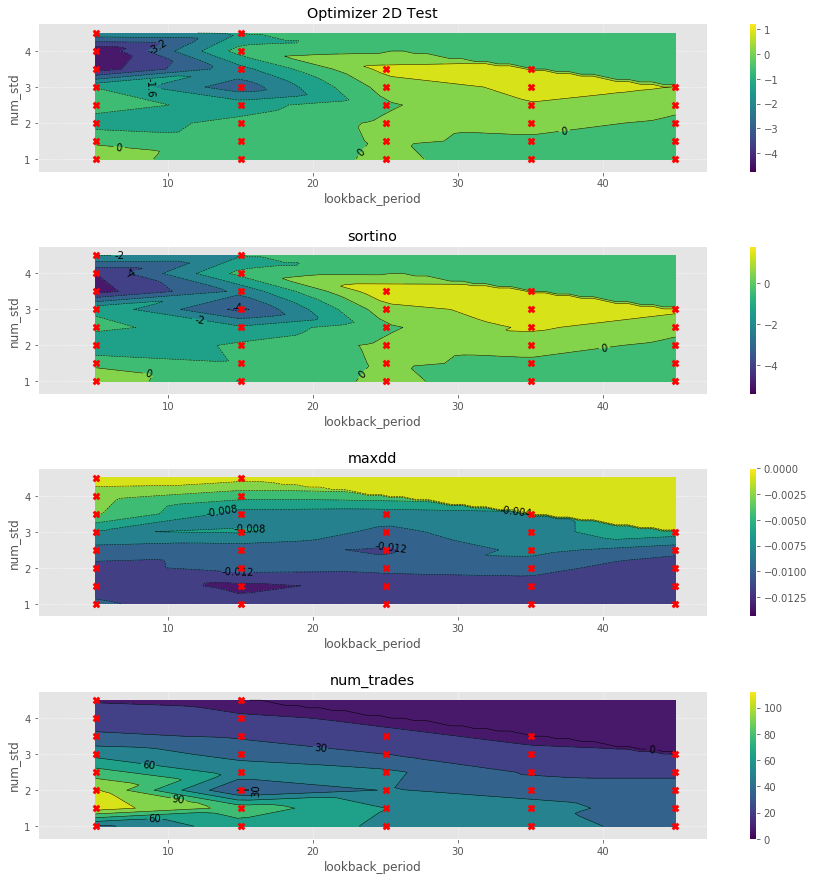

In [3]:
optimizer.plot_3d(x = 'lookback_period', y = 'num_std', plot_type = 'contour', hspace = 0.5, );

Lets look at the actual values of the sharpes, sortinos and drawdowns

In [4]:
optimizer.df_experiments(ascending = False)

,lookback_period,num_std,cost,sortino,maxdd,num_trades
22,35,3.5,1.2430104,1.7559291,-0.0084777319,12
16,25,3.5,1.0729695,1.8268238,-0.0090622877,18
23,35,3,1.012937,1.4952747,-0.008478335,18
30,45,3,0.7961109,1.2313715,-0.0069238166,16
24,35,2.5,0.75962796,1.181225,-0.0093516874,28
8,5,1,0.40632027,0.60866478,-0.011675927,41
18,25,3,0.35469235,0.59751966,-0.010564546,30
27,35,2,0.24838838,0.40253886,-0.011088696,40
31,45,2.5,0.16143386,0.26267548,-0.011174667,28
21,25,1,0.15735124,0.26729295,-0.013425413,58


In [5]:
optimizer.df_experiments(sort_column = 'maxdd', ascending = False)

,lookback_period,num_std,cost,sortino,maxdd,num_trades
0,5,4.5,-1.7463656,-1.9838111,-0.00092855502,14
14,15,4.5,-1.5388708,-2.0805162,-0.0011610354,12
1,5,4,-4.7472482,-5.0028043,-0.0031427809,21
2,5,3.5,-4.4712913,-5.4236788,-0.0037626221,33
13,15,4,-0.43475481,-0.67351583,-0.0052054042,16
30,45,3,0.7961109,1.2313715,-0.0069238166,16
10,15,3,-2.9178149,-4.2877032,-0.0077760725,40
3,5,3,-0.81689261,-1.183652,-0.0081566393,55
22,35,3.5,1.2430104,1.7559291,-0.0084777319,12
23,35,3,1.012937,1.4952747,-0.008478335,18


Let's run the strategy at a lookback period of 35 bars with 3 standard deviations to verify the results

,gmean,amean,std,shrp,srt,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2019
,0.04455,0.0001769,0.00282,0.996,1.474,-5.259,-5.259,-0.008478,2019-02-14/2019-02-15,-0.008478,2019-02-14/2019-02-15,9/7/0.562,0.04455


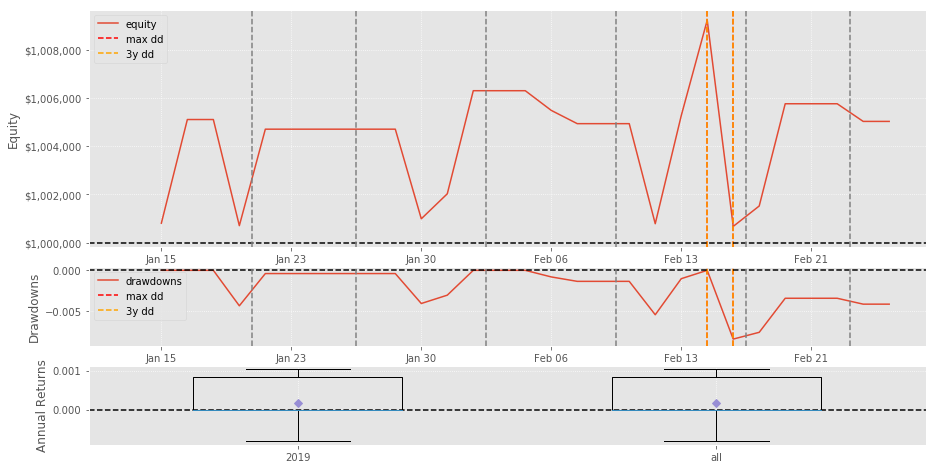

In [6]:
strategy = build_example_strategy(SimpleNamespace(lookback_period = 35, num_std = 3))
strategy.run()
strategy.evaluate_returns();

This confirms that lookback period somewhere around 35 bars with 3 standard deviations gives us a positive sharpe and sortino and lower drawdowns.  This is a toy example, and in real life you would want to run with a lot more data, look at the stability of this region and do other out of sample testing before you can use this strategy with real money.